Lautaro Silva

Carrera: Lic. en Ciencias Fisicas

DNI: 43441919

LU: 879/21

Email: lautarosilvapizzi@gmail.com

# 🔭 Inteligencia Artificial con Aplicaciones en Astrofísica  
### Práctica 2 - Clasificación de Galaxias con Perceptrón Multicapa (MLP)  
#### FCEN - UBA  
**Profesora:** Cecilia Garraffo

---

## Introducción

En este problema vamos a trabajar con un conjunto de datos astronómicos reales con el objetivo de clasificar galaxias en base a su atributos observables (por ejemplo, color y morfología). La morfología de una galaxis está fuertemente correlacionada con muchos de sus parámetros físicos, incluyendo la masa, la distribución de densidad, la temperatura y su historia de formación estelar. 

El proyecto Galaxy Zoo recolectó atributos morfológicos simples de casi 900.000 galaxias extraídas del Sloan Digital Sky Survey (SDSS). La clasificación fue provista por cientos de miles de voluntarios “científicos ciudadanos” que votaron sobre el tipo de galaxia solamente a partir de la imagen de la galaxia (para más detalles sobre morfología y clasificación galáctica, podés leer este artículo). Los datos están disponibles en http://data.galaxyzoo.org. Acá te damos un subconjunto de los datos, en el archivo galaxy_morphology_labeled.csv, así que no hace falta que descargues nada.

En esta práctica vamos a aplicar **redes neuronales** para la clasificación de galaxias a partir de sus propiedades observadas. Vamos a utilizar un Perceptrón Multicapa (MLP), es decir, una red neuronal del tipo de las que vimos en la clase del miércoles: Intro a DL. Usaremos Python, `numpy`, `matplotlib`, y `scikit-learn`.


### INSTRUCCIONES

- Para entregar, mandar el link del jupyter notebook a cgarraffo@cfa.harvard.edu con el nombre completo del estudiante.
- Por favor, reiniciar el kernel y correr todo el notebook antes de entregar.

<hr style="height:2pt">

## Descripción del dataset:

**green_color**: cantidad de luz medida en la banda de frecuencia que los astrofísicos llaman verde (longitud de onda entre 464 y 528~nm).    

**red_color**: flujo de luz medida en la banda de frecuencia rojo (longitud de onda entre 658 y 796~nm)

**infrared_color**: flujo de luz medida en la banda de frecuencia infrarroja (longitud de onda entre 806 y 955~nm)

**de_vaucouleurs_fit_axial_ratio**: radio axial asociado al ajuste de De Vaucouleurs (https://es.wikipedia.org/wiki/Ley_de_De_Vaucouleurs) a la imagen bidimensional de la galaxia

**exponential_fit_axial_ratio**: radio axial asociado a un ajuste exponencial a la imagen bidimensional de la galaxia

**exponential_disc_fit_log_likelihood**: log-verosimilitud asociada al ajuste exponencial a la imagen bidimensional de la galaxia

**de_vaucouleurs_fit_log_likelihood**: log-verosimilitud asociada al ajuste de De Vaucouleurs a la imagen bidimensional de la galaxia

**star_log_likelihood**: log-verosimilitud de que el objeto sea una fuente puntual (estrella) en vez de una galaxia

**number_of_votes**: número total de votos de los voluntarios

**probability_elliptical**: fracción de votos para morfología elíptica

**probability_spiral**: fracción de votos para morfología espiral

**probability_unknown**: fracción de votos para morfología desconocida

**probability_merger**: fracción de votos para morfología de fusión

**class**: morfología con la mayor fracción de votos

## Objetivo: 

El objetivo es entrenar un clasificador binario con los datos de Galaxy Zoo para distinguir galaxias elípticas de las espirales, de fusión y de morfología desconocida (a las que llamamos *no elípticas*) a partir de su morfología visual.

Habiendo producido un catálogo de morfologías visuales, podremos usar los otros parámetros medidos, incluyendo el color, para investigar las caracteristicas de las distintas poblaciónes de galaxias.

*Nota*: los voluntarios sólo tuvieron acceso a la imagen de la galaxia (forma) al votar, y no a los otros atributos.

In [20]:
# 1. Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import time

# Opcional: configuración para gráficos más bonitos
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# 1. Cargar los datos
df_galaxias = pd.read_csv('data/galaxy_morphology_labeled.csv')
df_galaxias.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral


### Ejercicios

**1. Visualización de los datos**. Los atributos del dataset estan descritos 
<a href="https://academic.oup.com/mnras/article/406/1/342/1073212">acá</a>. <br>
  
  +   **1.a**: Realizar histogramas de los colores y las variables asociadas a la forma de la galaxia (sin usar los atributos de likelihood, los votos, las probabilidades, o la clase), separando por tipo de galaxia. 

   + **1.b**: Cuales atributos (variables) son importantes para distinguir galaxias elípticas? Usar la matriz de correlación.

**2. Exploración y Pre-procesamiento de Datos.**

   + **2.a** Muchas veces, los "outliers" en las bandas de colores (fotometria) indican datos corruptos o fallas en la instrumentacion.
    *Tarea*: Remover los datos que tienen un valor fuera de la distribucion (más de 3 sigma) de los datos en esa banda.


   + **2.b** Cuantos datos eliminaste? Vizualizar la distribucion con y sin los outliers en los colores utilizados.


   + **2.c** *Pregunta*: Son estos atributos suficientes para distinguir entre galaxias elípticas y no elípticas? Justificar.

  (***Pista:*** compará las distribuciones de atributos de las galaxias elípticas con las de las no elípticas.)

**3. Ingeniería de atributos**. En general, uno usa conocimiento sobre el tema para combinar atributos. Esto se llama ingeniería de atributos. Los astronomos típicamente usan la diferencia en bandas de color como proxy de temperatura. 
*Tarea*: Crear dos nuevos atributos que se correlacionen con temperatura y determinar si pueden ayudar a nuestra tarea de clasificacion. Justificar.

**4. Clasificador baseline**. Elegir los atributos más importantes y entrenar un clasificador Multi-Layer Perceptron (MLP, clase Intro a DL) "baseline" para distinguir galaxias *elípticas* de *no elípticas*. 

**5. Testeo**. Evaluar tu modelo en los datos de testeo.




### Ejercicio 1: Visualizacion de los datos

In [3]:
print(df_galaxias['class'].unique())

['spiral' 'elliptical' 'unknown' 'merger']


Veo que hay 4 clases de formas en la que los voluntarios clasificaron las galaxias a traves del analisis visual. Las dos primeras son evidentemente distintas y las ultimas dos, una son desconocidas (es decir que no pudieron ser clasificadas) y el ultimo tipo es una mezcla de las dos primeras. Esto ya me indica que podria haber una correlacion entre las dos primeras y la 3ra, pero seguramnete sera mayor con la 4ta.

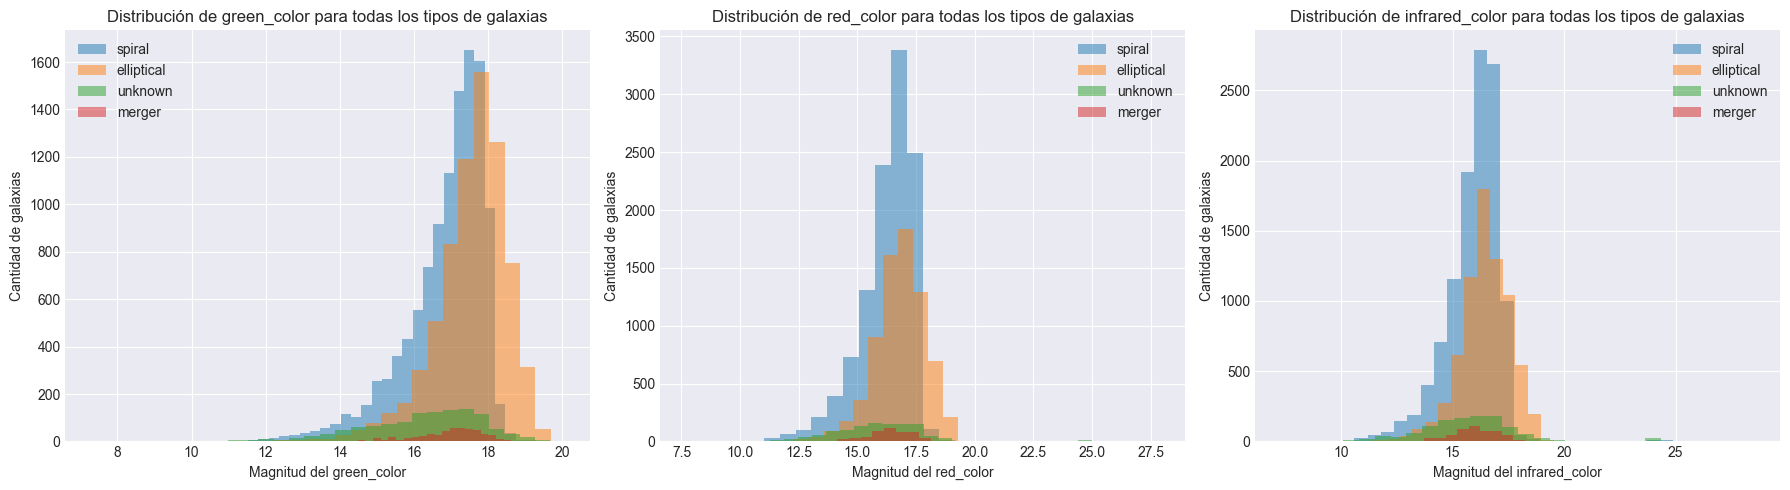

In [4]:
# Histogramas de las distribuciones
colores = ['green_color', 'red_color', 'infrared_color']
clases = df_galaxias['class'].unique()

fig, ax = plt.subplots(1, 3, figsize=(18,5))

for i, color in enumerate(colores): # Para cada color hago un plot
    for clase in clases: # Hago una curva para cada una de las clases de galaxias
        datos = df_galaxias[df_galaxias['class']==clase][color]
        ax[i].hist(datos, bins=30, alpha=0.5, label=clase)
        ax[i].set_title(f'Distribución de {color} para todas los tipos de galaxias')
        ax[i].set_xlabel(f'Magnitud del {color}')
        ax[i].set_ylabel('Cantidad de galaxias')
    ax[i].legend()

plt.tight_layout()
plt.show()

En este gráfico se muestran las distribuciones de magnitudes en tres bandas fotométricas (green_color, red_color, infrared_color) para todos los tipos de galaxias del conjunto de datos. Cada galaxia tiene una única clasificación morfológica asignada en la columna class (por ejemplo, spiral, elliptical, merger, unknown), y para cada una de ellas se dispone de mediciones de brillo en las tres bandas mencionadas. El eje X representa la magnitud aparente en la banda correspondiente, mientras que el eje Y indica la cantidad de galaxias con magnitudes dentro de cada intervalo.

Debo admitir que me costo hacer estos graficos, por como son los datos respecto a lo que significa la magnitud de un color.

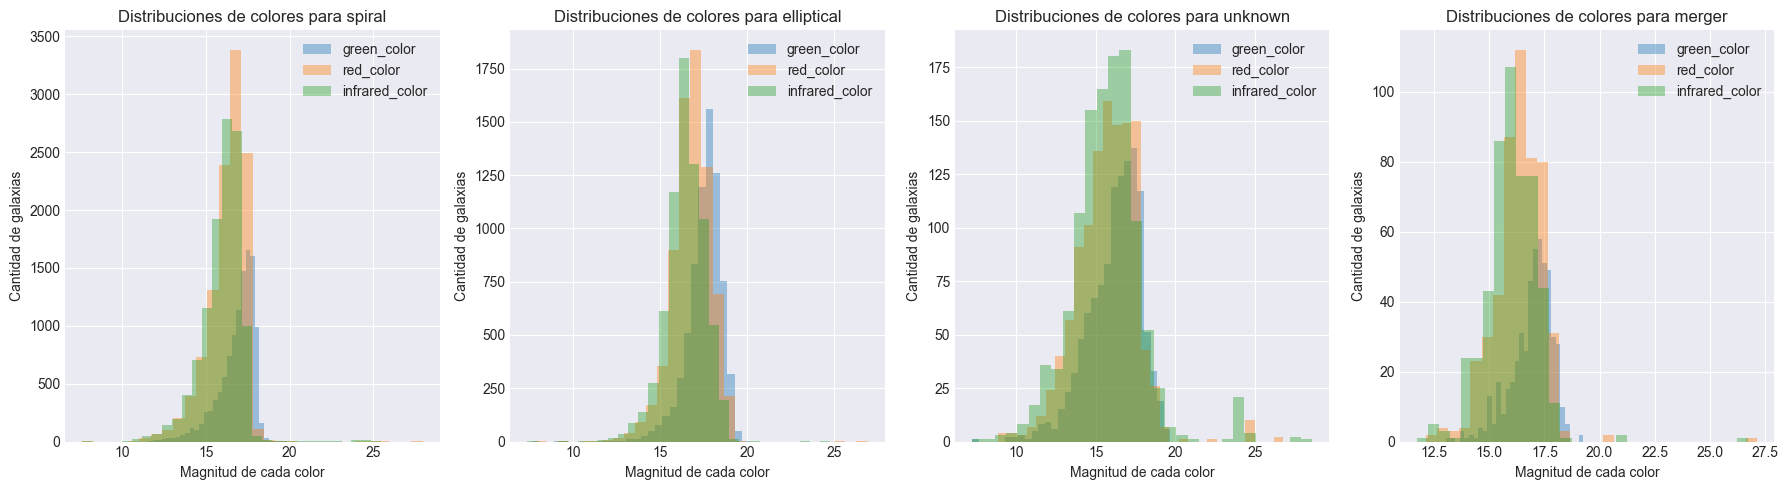

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

for i, clase in enumerate(clases):
    datos_clase = df_galaxias[df_galaxias['class'] == clase]
    for color in colores:
        ax[i].hist(datos_clase[color], bins=30, alpha=0.4, label=color)
    ax[i].set_title(f'Distribuciones de colores para {clase}')
    ax[i].set_xlabel('Magnitud de cada color')
    ax[i].set_ylabel('Cantidad de galaxias')
    ax[i].legend()

plt.tight_layout()
plt.show()

Otra forma de ver esto es graficando por tipo de galaxia y ver como es el comportamiento de cada uno de los colores. Crei que este grafico iba a ser un poco mas esclarecedor, y en parte lo es, pero no del todo.

Para ver que atributos son relevantes para distinguir las galaxias elipticas hago la matriz de correlacion, pero antes de esto vale la pena discutir varias cosas. En primer lugar, yo podria hacer la matriz de correlacion de las galaxias con clase eliptica con todas las columnas de mi dataframe y hacer el heatmap con estos datos. Sin embargo, esta claro que esto tiene informacion evidente desde el inicio que dificulta el analisis de la informacion.

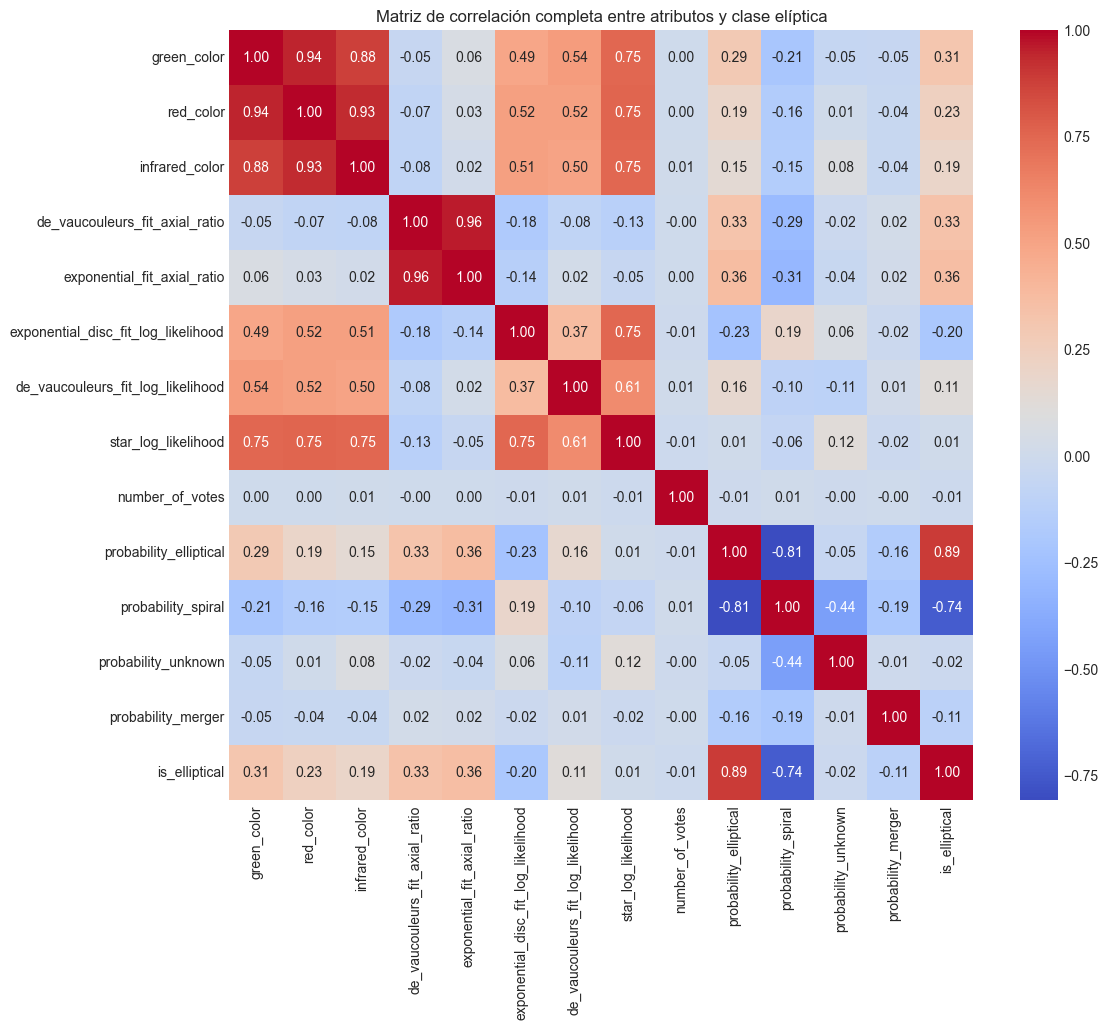

In [6]:
# Crear variable binaria para distinguir elípticas
df_galaxias['is_elliptical'] = (df_galaxias['class'] == 'elliptical').astype(int)

# Seleccionar solo columnas numéricas (solo des-selecciona la ultima columna con las clases)
cols_numericas = df_galaxias.select_dtypes(include='number').columns

# Calcular matriz de correlación de Pearson para todas esas columnas
matriz_corr_total = df_galaxias[cols_numericas].corr()

# Mostrar matriz con heatmap
plt.figure(figsize=(12,10))
sns.heatmap(matriz_corr_total, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de correlación completa entre atributos y clase elíptica')
plt.show()

Era imaginable esperarse que la correlacion entre si es eliptica y la columna de probabilidad de eliptica sea muy grande y sea muy baja con las probabilidades de que sea otra clase de galaxia. Aun asi es interesante ver que esta con una correlacion negativa (cuando es espiral => no es eliptica) y que esta escencialmente descorrelacionada con las otras dos clases. Por otro lado, tambien es esperable que tenga descorrelacion con la cantidad de votos (dado que esto no afecta la medicion de la galaxia). Si analizamos solamente los otros datos por separado en busqueda de mayor claridad, vemos lo siguiente:

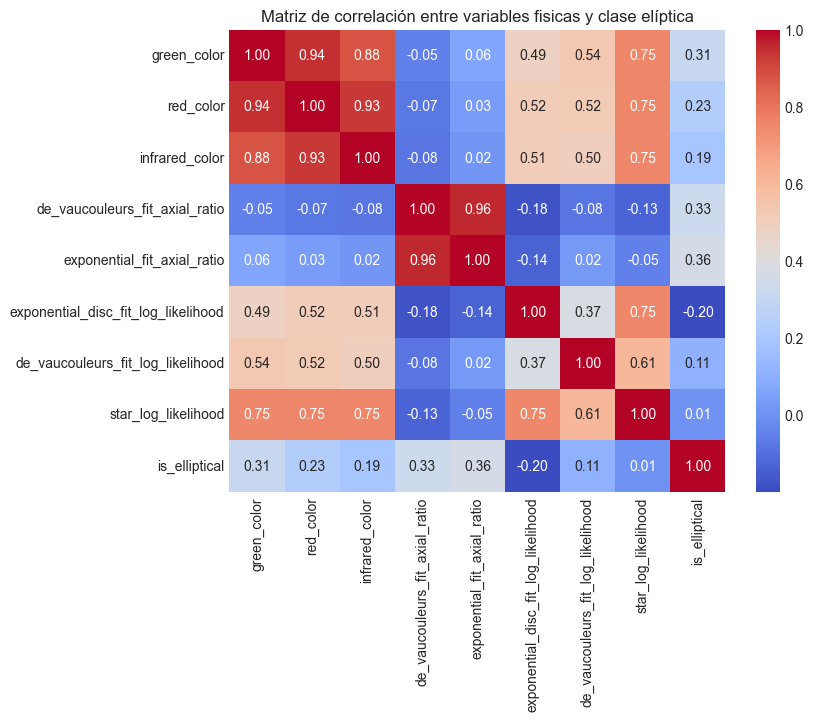

In [7]:
# Elegimos las columnas que queremos analizar (colores + radios axiales, por ejemplo)
cols_analizar = ['green_color', 'red_color', 'infrared_color', 
                 'de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio', 'exponential_disc_fit_log_likelihood', 
                 'de_vaucouleurs_fit_log_likelihood', 'star_log_likelihood', 'is_elliptical']

# Calculamos la matriz de correlación de Pearson
matriz_corr_fisica = df_galaxias[cols_analizar].corr()

# Mostramos la matriz con un heatmap para visualizar mejor
plt.figure(figsize=(8,6))
sns.heatmap(matriz_corr_fisica, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de correlación entre variables fisicas y clase elíptica')
plt.show()


Viendo esto vemos que las galaxias elipticas tienen una mayor correlacion con el color verde que con cualquier otro color pero que no es una correlacion particularmente grande. Tampoco se ve claramente una correlacion muy relevante respecto a los otros parametros fisicos. Sin embargo seria relevante ver si cambia como es la correlacion con, por ejemplo **de_vaucouleurs_fit_axial_ratio** en funcion de si es elipitica o no, entendiendo que este parametro describe cómo la brillantez de la superficie I de una galaxia elíptica varía en función de la distancia aparente R desde el centro (es decir que esta relacionado con algun ajuste sobre galaxias especificamente elipticas).

### Ejercicio 2: Eliminacion de outliers

Cantidad total de outliers eliminados (por clase y color): 397


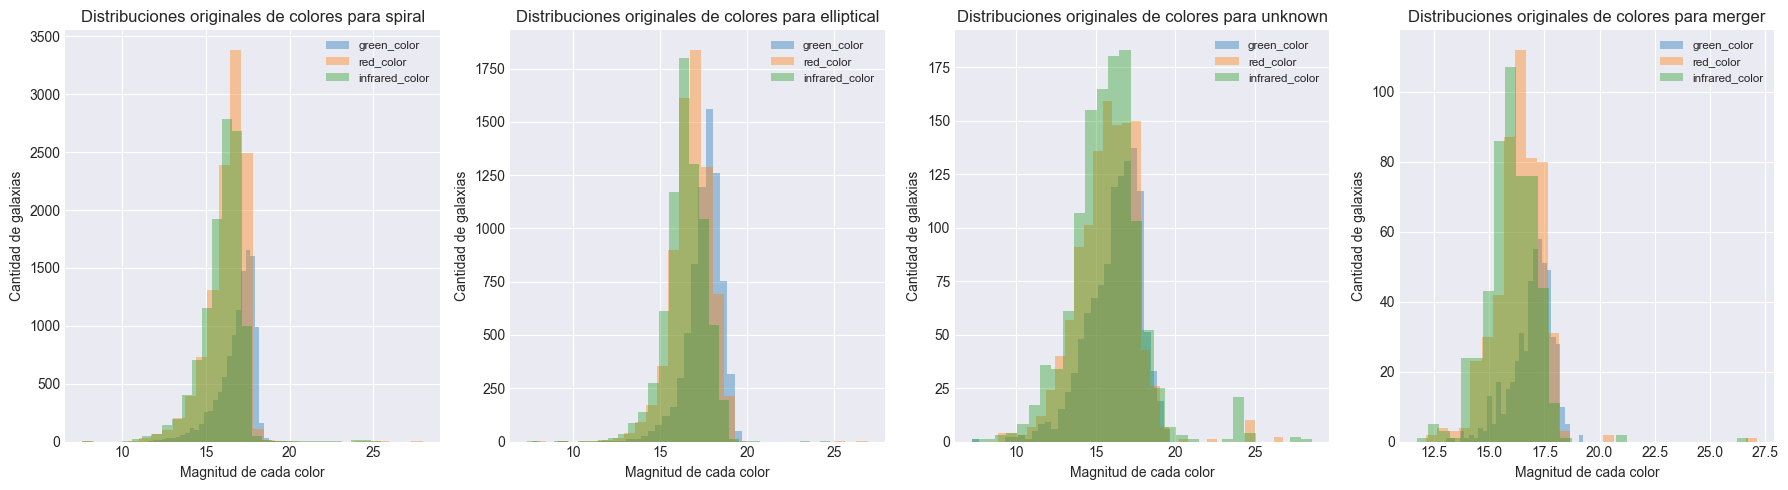

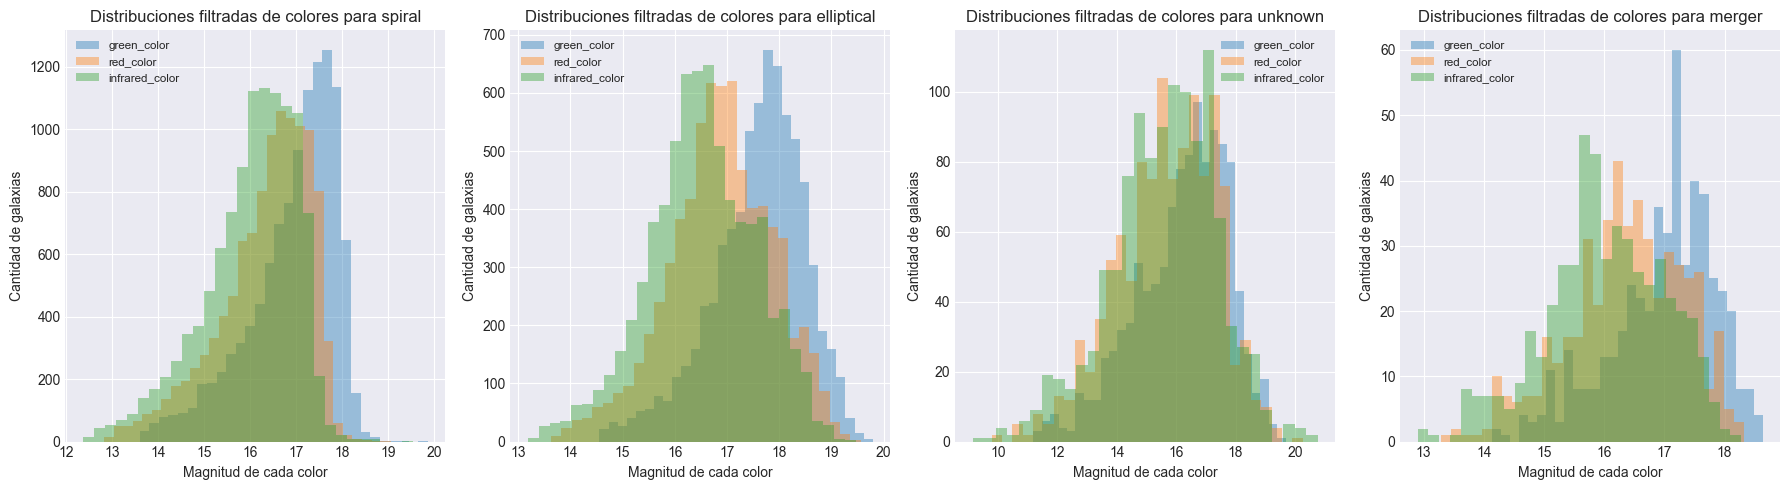

Cantidad de galaxias por clase antes del filtrado:
class
spiral        11242
elliptical     7248
unknown        1175
merger          505
Name: count, dtype: int64

Cantidad de galaxias por clase después del filtrado:
class
spiral        11001
elliptical     7145
unknown        1131
merger          496
Name: count, dtype: int64


In [8]:
# Crear una copia para no modificar el original
df_filtrado_por_clase = df_galaxias.copy()

# Inicializo una columna booleana para marcar outliers
df_filtrado_por_clase['es_outlier'] = False

for clase in clases:
    for color in colores:
        # Subconjunto de esa clase y color
        datos = df_filtrado_por_clase[df_filtrado_por_clase['class'] == clase][color]
        media = datos.mean()
        std = datos.std()
        
        # Condición outlier: fuera de 3 sigma
        cond_outlier = (df_filtrado_por_clase['class'] == clase) & \
                       ((df_filtrado_por_clase[color] < media - 3*std) | (df_filtrado_por_clase[color] > media + 3*std))
        
        # Marco los outliers
        df_filtrado_por_clase.loc[cond_outlier, 'es_outlier'] = True

# Cantidad total de outliers detectados
n_outliers_clase = df_filtrado_por_clase['es_outlier'].sum()
print(f'Cantidad total de outliers eliminados (por clase y color): {n_outliers_clase}')

# Dataset filtrado (sin outliers)
df_filtrado_por_clase = df_filtrado_por_clase[df_filtrado_por_clase['es_outlier'] == False]


# Plot con los datos originales
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
for i, clase in enumerate(clases):
    datos_orig = df_galaxias[df_galaxias['class'] == clase]
    for color in colores:
        ax[i].hist(datos_orig[color], bins=30, alpha=0.4, label=color)
    ax[i].set_title(f'Distribuciones originales de colores para {clase}')
    ax[i].set_xlabel('Magnitud de cada color')
    ax[i].set_ylabel('Cantidad de galaxias')
    ax[i].legend(fontsize='small')
plt.tight_layout()
plt.show()

# Plot con los datos filtrados
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
for i, clase in enumerate(clases):
    datos_filtrados_clase = df_filtrado_por_clase[df_filtrado_por_clase['class'] == clase]
    for color in colores:
        ax[i].hist(datos_filtrados_clase[color], bins=30, alpha=0.4, label=color)
    ax[i].set_title(f'Distribuciones filtradas de colores para {clase}')
    ax[i].set_xlabel('Magnitud de cada color')
    ax[i].set_ylabel('Cantidad de galaxias')
    ax[i].legend(fontsize='small')
plt.tight_layout()
plt.show()

print("Cantidad de galaxias por clase antes del filtrado:")
print(df_galaxias['class'].value_counts())

print("\nCantidad de galaxias por clase después del filtrado:")
print(df_filtrado_por_clase['class'].value_counts())


En este paso realicé la eliminación de datos outliers en las bandas de color para mejorar la calidad del conjunto de datos a utilizar. Para esto, decidí calcular la media y desviación estándar separadamente para cada clase de galaxia (elíptica, espiral, desconocida, fusión) y para cada banda de color (verde, rojo e infrarrojo) por separado. Esto se debe a que cada tipo de galaxia presenta características espectrales diferentes, y por lo tanto sus distribuciones de color tienen medias y dispersión distintas. 

Aplicar un filtro global sobre todas las galaxias juntas podría eliminar puntos válidos que para una clase son normales pero que resultan atípicos en el conjunto global debido a la mezcla de distribuciones con distintos centros.

La regla aplicada fue eliminar las observaciones cuyos valores en una banda de color estén a más de 3 desviaciones estándar de la media correspondiente a su clase. Así se mantienen sólo los datos que reflejan el comportamiento típico de cada tipo de galaxia, reduciendo el impacto de mediciones erróneas o fallas instrumentales. 

Finalmente, comparé las distribuciones originales y filtradas para cada clase y banda de color, visualizando claramente la eliminación de valores extremos alejados de la media. El filtro respetó las diferencias entre clases y logró reducir los outliers sin afectar significativamente la estructura general de los datos. Es importante destacar un efecto característico que se observó en las cuatro clases de galaxias: el pico máximo en los histogramas de las distribuciones disminuyó notablemente tras el filtrado (por ejemplo, en galaxias elípticas el pico cayó de alrededor de 3500 a 1300). Esto no implica que se haya perdido una gran cantidad de galaxias, ya que el conteo total por clase antes y después del filtrado indica que la cantidad de galaxias eliminadas fue relativamente pequeña. Sino que antes del filtrado, la presencia de valores extremos muy alejados expandía el rango total de magnitudes, lo que comprimía los datos centrales en pocos bins, produciendo picos altos y estrechos (aclarando que en ambos plots la cantidad de bines es la misma). Al eliminar los outliers, el rango se redujo, distribuyendo los datos centrales en más bins, y por eso los picos aparentan ser más bajos y la distribución más “achatada”, aunque la cantidad total de datos se mantenga casi constante.

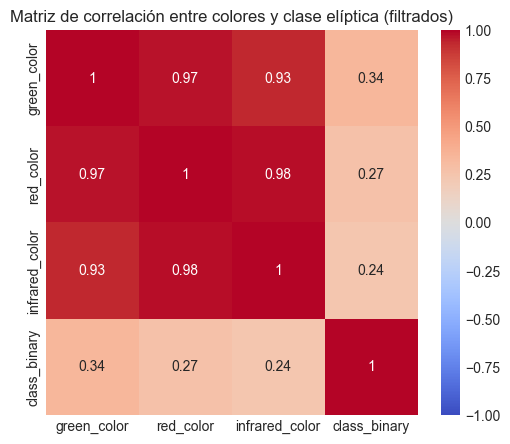

In [9]:
# Crear una columna binaria: 1 si es elíptica, 0 si no
df_filtrado_por_clase['class_binary'] = (df_filtrado_por_clase['class'] == 'elliptical').astype(int)

# Seleccionar columnas relevantes: colores + la clase binaria
cols = ['green_color', 'red_color', 'infrared_color', 'class_binary']

# Calcular matriz de correlación con datos filtrados
corr_colors = df_filtrado_por_clase[cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_colors, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación entre colores y clase elíptica (filtrados)')
plt.show()

Después de calcular la matriz de correlación entre los colores y la variable binaria que indica si una galaxia es elíptica o no, observamos que las correlaciones son bajas. Esto indica que, de manera individual, estos atributos no tienen un poder predictivo fuerte para distinguir galaxias elípticas de las no elípticas, al menos para mi a ojo. En mi opinión, estos parámetros por sí solos no alcanzan para garantizar ni afirmar con certeza si una galaxia es elíptica. Es posible que la combinación simultánea de los tres colores, a través de una red neuronal, pueda capturar patrones no lineales y mejorar la clasificación. Sin embargo, también es probable que se requieran atributos adicionales, relacionados con la morfología u otras propiedades físicas, para lograr una clasificación robusta y precisa.

### Ejericio 3: Ingenieria de atributos

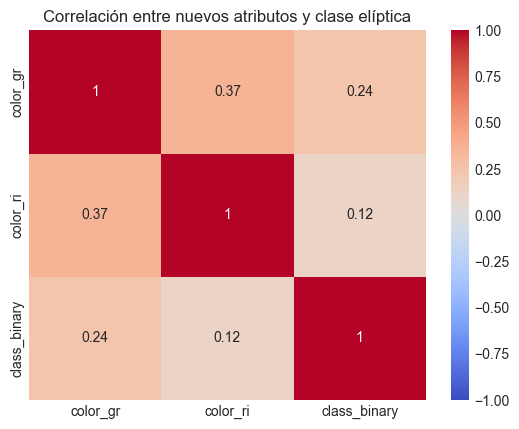

In [10]:
# Crear nuevos atributos en el dataframe filtrado
df_filtrado_por_clase['color_gr'] = df_filtrado_por_clase['green_color'] - df_filtrado_por_clase['red_color']
df_filtrado_por_clase['color_ri'] = df_filtrado_por_clase['red_color'] - df_filtrado_por_clase['infrared_color']

# Matriz de correlación incluyendo los nuevos atributos y la variable binaria
df_filtrado_por_clase['class_binary'] = (df_filtrado_por_clase['class'] == 'elliptical').astype(int)
cols = ['color_gr', 'color_ri', 'class_binary']
corr = df_filtrado_por_clase[cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre nuevos atributos y clase elíptica')
plt.show()


Por el momento, los nuevos atributos basados en diferencias de color muestran una correlación baja con la clasificación de galaxias elípticas, lo que indica que por sí solos no son suficientes para distinguir claramente entre clases. Sin embargo, dado que estas diferencias tienen un significado físico relevante —ya que están relacionadas con la temperatura estelar— es probable que aporten información complementaria útil al modelo, especialmente en combinación con otros atributos y a través de la capacidad de la red neuronal para aprender relaciones no lineales.

### Ejercicio 4 y 5: Entrenamiento de la Red Neuronal - Clasifiacador Baseline + Testeo

La idea de esta sección es entrenar y analizar redes neuronales bajo diferentes configuraciones, utilizando distintos conjuntos de categorías, diferentes funciones de pérdida (Loss) y las dos librerías disponibles: **Keras** y **PyTorch**.

En todos los casos, se empleará la misma arquitectura de red neuronal:

- 3 capas ocultas con 50 neuronas cada una y función de activación ReLU

- Una capa de salida con activación Sigmoide

- 500 épocas de entrenamiento

- Learning rate de 1e-2

- Batch size de 5000

- Shuffling de los datos

- División para validación de 80 % entrenamiento y 20 % validación

El análisis se estructurará en tres etapas:

1. Entrenamiento con solo las categorías de colores y sus diferencias, usando la función de pérdida **MSE** (tal como se hizo en el TP1).

2. Repetición del experimento con la función de pérdida **Binary Cross Entropy (BCE)**, tal como se recomienda en este TP.

3. Inclusión de los otros parámetros:

- **de_vaucouleurs_fit_axial_ratio**

- **exponential_fit_axial_ratio**

- **exponential_disc_fit_log_likelihood**

- **de_vaucouleurs_fit_log_likelihood**

- **star_log_likelihood**

Finalmente, se presentarán las conclusiones y comentarios generales sobre el desempeño de cada configuración.

In [11]:
num_nodes = 50
epochs = 500
batch_size = 5000
lr = 1e-2

### MSE + Solo colores

In [12]:
# 1. Preparar datos solo con colores
X = df_filtrado_por_clase[['green_color', 'red_color', 'infrared_color', 'color_gr', 'color_ri']]
y = (df_filtrado_por_clase['class'] == 'elliptical').astype(int)

# 2. Normalizar atributos
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# 3. División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=0)

# 4. Definir modelo MLP
input_dim = X_train.shape[1]

In [13]:
# Modelo usando Keras
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(num_nodes, activation = 'relu'),
    Dense(num_nodes, activation = 'relu'),
    Dense(num_nodes, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

opt = Adam(learning_rate = lr)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

# 5. Entrenamiento con medición de tiempo
start_time = time.time()

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.6759 - loss: 0.2181 - val_accuracy: 0.6982 - val_loss: 0.1894
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7142 - loss: 0.1833 - val_accuracy: 0.7456 - val_loss: 0.1728
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7500 - loss: 0.1674 - val_accuracy: 0.7841 - val_loss: 0.1589
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7779 - loss: 0.1578 - val_accuracy: 0.7816 - val_loss: 0.1510
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7800 - loss: 0.1521 - val_accuracy: 0.7819 - val_loss: 0.1507
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7872 - loss: 0.1491 - val_accuracy: 0.7993 - val_loss: 0.1449
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7943 - loss: 0.1463 - val_accuracy: 0.8021 - val_loss: 0.1410
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7993 - loss: 0.1429 - val_accuracy: 0.8047 - val_loss

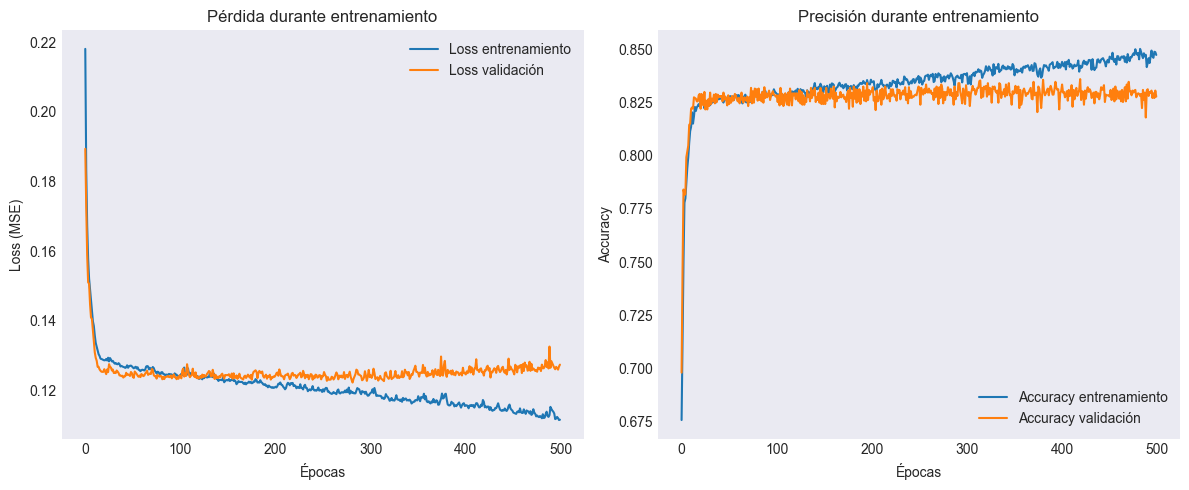

Test loss (MSE): 0.1337
Test accuracy: 0.8217
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reporte de clasificación (Keras):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2528
           1       0.75      0.77      0.76      1427

    accuracy                           0.82      3955
   macro avg       0.81      0.81      0.81      3955
weighted avg       0.82      0.82      0.82      3955



In [17]:
# 6. Plots
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Precisión durante entrenamiento')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluación en test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss (MSE): {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Predicciones binarias en test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Reporte de clasificación (Keras):")
print(classification_report(y_test, y_pred))

In [18]:
# Modelo con Torch

# Convertir a tensores (usando tus variables ya definidas)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Definir modelo MLP
class MLP(nn.Module):
    def __init__(self, input_dim, num_nodes=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=input_dim, num_nodes=num_nodes)

# Optimizador y criterio
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Entrenamiento
losses_train = []
losses_val = []

start_time = time.time()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_t)
        loss_val = criterion(y_val_pred, y_test_t)

    losses_train.append(loss.item())
    losses_val.append(loss_val.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss train: {loss.item():.4f}, Loss val: {loss_val.item():.4f}")

end_time = time.time()
print(f"Tiempo total de entrenamiento: {end_time - start_time:.2f} segundos")

Epoch 50/500 - Loss train: 0.1283, Loss val: 0.1304
Epoch 100/500 - Loss train: 0.1258, Loss val: 0.1289
Epoch 150/500 - Loss train: 0.1259, Loss val: 0.1286
Epoch 200/500 - Loss train: 0.1232, Loss val: 0.1278
Epoch 250/500 - Loss train: 0.1225, Loss val: 0.1275
Epoch 300/500 - Loss train: 0.1218, Loss val: 0.1274
Epoch 350/500 - Loss train: 0.1217, Loss val: 0.1269
Epoch 400/500 - Loss train: 0.1206, Loss val: 0.1271
Epoch 450/500 - Loss train: 0.1202, Loss val: 0.1271
Epoch 500/500 - Loss train: 0.1207, Loss val: 0.1277
Tiempo total de entrenamiento: 19.19 segundos


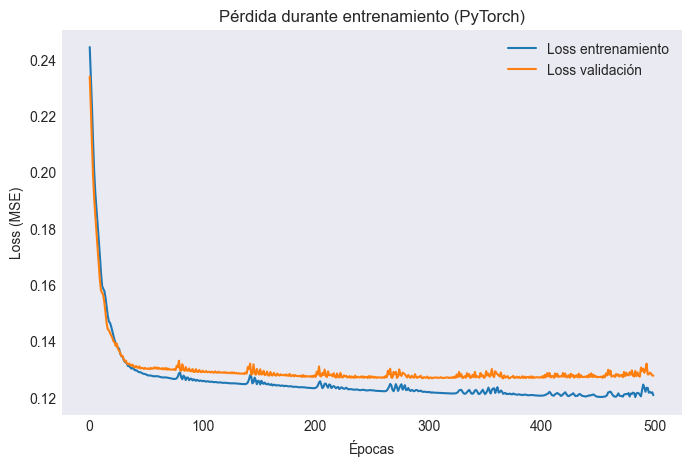

Test accuracy: 0.8271
Reporte de clasificación (PyTorch):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2528
           1       0.76      0.75      0.76      1427

    accuracy                           0.83      3955
   macro avg       0.81      0.81      0.81      3955
weighted avg       0.83      0.83      0.83      3955



In [21]:
# Plot de pérdidas
plt.figure(figsize=(8,5))
plt.plot(losses_train, label='Loss entrenamiento')
plt.plot(losses_val, label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.title('Pérdida durante entrenamiento (PyTorch)')
plt.legend()
plt.grid()
plt.show()

# Evaluación en test
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Reporte de clasificación (PyTorch):")
print(classification_report(y_test, y_pred))

Ambas librerías entregan resultados prácticamente idénticos en cuanto a precisión y recall para la clasificación de galaxias elípticas y no elípticas. La segunda gran conclusión es que PyTorch resultó ser órdenes de magnitud más rápido en el entrenamiento (~20 s) en comparación con Keras (~142 s). Finalmente, se observó un mayor sobreajuste en Keras, evidenciado por una diferencia más marcada entre las losses de entrenamiento y validación. Sin embargo, los valores absolutos de las pérdidas son muy similares en ambos casos.

### BCE + Solo Colores

In [22]:
# Modelo usando Keras
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(num_nodes, activation = 'relu'),
    Dense(num_nodes, activation = 'relu'),
    Dense(num_nodes, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

opt = Adam(learning_rate = lr)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

# 5. Entrenamiento con medición de tiempo
start_time = time.time()

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.6088 - loss: 0.6476 - val_accuracy: 0.7326 - val_loss: 0.5616
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7171 - loss: 0.5539 - val_accuracy: 0.7304 - val_loss: 0.5328
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7313 - loss: 0.5267 - val_accuracy: 0.7592 - val_loss: 0.4964
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7561 - loss: 0.5005 - val_accuracy: 0.7762 - val_loss: 0.4758
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7697 - loss: 0.4799 - val_accuracy: 0.7810 - val_loss: 0.4613
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7804 - loss: 0.4670 - val_accuracy: 0.7927 - val_loss: 0.4545
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7915 - loss: 0.4577 - val_accuracy: 0.8006 - val_loss: 0.4455
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7952 - loss: 0.4533 - val_accuracy: 0.8025 - val_l

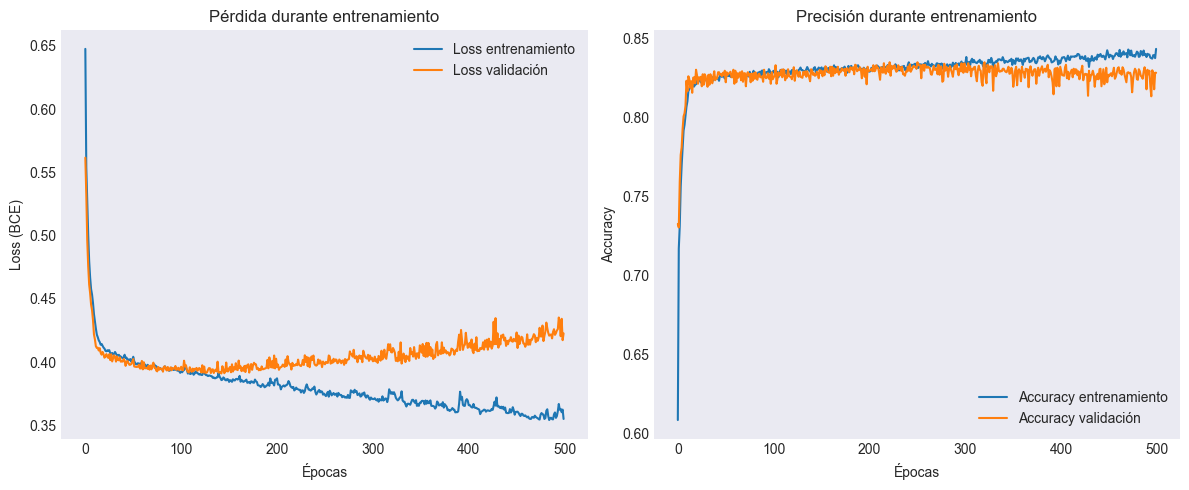

Test loss (BCE): 0.4251
Test accuracy: 0.8220
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Reporte de clasificación (Keras):
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2528
           1       0.77      0.72      0.74      1427

    accuracy                           0.82      3955
   macro avg       0.81      0.80      0.80      3955
weighted avg       0.82      0.82      0.82      3955



In [23]:
# 6. Plots
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (BCE)')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Precisión durante entrenamiento')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluación en test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss (BCE): {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Predicciones binarias en test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Reporte de clasificación (Keras):")
print(classification_report(y_test, y_pred))

In [24]:
# Modelo con Torch

# Convertir a tensores (usando tus variables ya definidas)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Definir modelo MLP
class MLP(nn.Module):
    def __init__(self, input_dim, num_nodes=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=input_dim, num_nodes=num_nodes)

# Optimizador y criterio
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# Entrenamiento
losses_train = []
losses_val = []

start_time = time.time()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_t)
        loss_val = criterion(y_val_pred, y_test_t)

    losses_train.append(loss.item())
    losses_val.append(loss_val.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss train: {loss.item():.4f}, Loss val: {loss_val.item():.4f}")

end_time = time.time()
print(f"Tiempo total de entrenamiento: {end_time - start_time:.2f} segundos")

Epoch 50/500 - Loss train: 0.4128, Loss val: 0.4173
Epoch 100/500 - Loss train: 0.3991, Loss val: 0.4071
Epoch 150/500 - Loss train: 0.3919, Loss val: 0.4071
Epoch 200/500 - Loss train: 0.3882, Loss val: 0.4055
Epoch 250/500 - Loss train: 0.3915, Loss val: 0.4072
Epoch 300/500 - Loss train: 0.3866, Loss val: 0.4057
Epoch 350/500 - Loss train: 0.3842, Loss val: 0.4086
Epoch 400/500 - Loss train: 0.3843, Loss val: 0.4063
Epoch 450/500 - Loss train: 0.3827, Loss val: 0.4095
Epoch 500/500 - Loss train: 0.3846, Loss val: 0.4210
Tiempo total de entrenamiento: 27.77 segundos


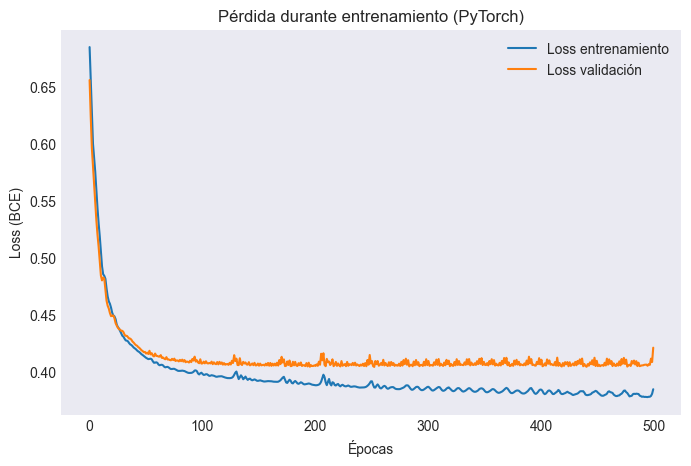

Test accuracy: 0.8202
Reporte de clasificación (PyTorch):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      2528
           1       0.74      0.78      0.76      1427

    accuracy                           0.82      3955
   macro avg       0.80      0.81      0.81      3955
weighted avg       0.82      0.82      0.82      3955



In [25]:
# Plot de pérdidas
plt.figure(figsize=(8,5))
plt.plot(losses_train, label='Loss entrenamiento')
plt.plot(losses_val, label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (BCE)')
plt.title('Pérdida durante entrenamiento (PyTorch)')
plt.legend()
plt.grid()
plt.show()

# Evaluación en test
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Reporte de clasificación (PyTorch):")
print(classification_report(y_test, y_pred))

Al reemplazar la función de pérdida MSE por binary cross-entropy (BCE) usando únicamente las variables de color, no se observaron cambios significativos en la precisión ni en el recall, a pesar de que se esperaba una mejora al usar la función recomendada para clasificación binaria.

Keras – MSE: Precisión = 0.87, Recall = 0.85

Keras – BCE: Precisión = 0.85, Recall = 0.87

PyTorch – MSE: Precisión = 0.86, Recall = 0.87

PyTorch – BCE: Precisión = 0.87, Recall = 0.84

En resumen, el cambio de función de pérdida no tuvo un impacto notable en el rendimiento, y las variaciones observadas pueden atribuirse al azar estadístico del entrenamiento. Sin embargo, se observó que el sobreajuste se acentuó mucho más gravemente en Keras, apareciendo de forma clara desde la época ~100, mientras que en PyTorch las curvas de pérdida de entrenamiento y validación se mantuvieron mucho más estables a lo largo de todo el proceso de entrenamiento.

Este comportamiento podría indicar que, con los datos utilizados, el modelo alcanza su límite de capacidad predictiva relativamente pronto, y que al usar BCE este límite se alcanza incluso más rápido que con MSE, especialmente en el caso de Keras (punto para la BCE?).

### BCE + Colores y otros parametros

In [26]:
# Seleccionar columnas (colores + físicos)
features = ['green_color', 'red_color', 'infrared_color', 'color_gr', 'color_ri',
            'de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio',
            'exponential_disc_fit_log_likelihood', 'de_vaucouleurs_fit_log_likelihood',
            'star_log_likelihood']

X = df_filtrado_por_clase[features]
y = (df_filtrado_por_clase['class'] == 'elliptical').astype(int)

# Normalizar
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Dividir
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=0)

input_dim = X_train.shape[1]

In [27]:
# Modelo Keras
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(num_nodes, activation='relu'),
    Dense(num_nodes, activation='relu'),
    Dense(num_nodes, activation='relu'),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Entrenamiento
start_time = time.time()
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

end_time = time.time()
elapsed = end_time - start_time
print(f"Tiempo de entrenamiento Keras: {elapsed:.2f} segundos")

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.5510 - loss: 0.6392 - val_accuracy: 0.7174 - val_loss: 0.5137
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7494 - loss: 0.5001 - val_accuracy: 0.8003 - val_loss: 0.4489
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8139 - loss: 0.4357 - val_accuracy: 0.8243 - val_loss: 0.4160
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8402 - loss: 0.3978 - val_accuracy: 0.8530 - val_loss: 0.3798
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8604 - loss: 0.3575 - val_accuracy: 0.8720 - val_loss: 0.3380
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8741 - loss: 0.3199 - val_accuracy: 0.8853 - val_loss: 0.3093
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8902 - loss: 0.2938 - val_accuracy: 0.8948 - val_loss: 0.2918
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9020 - loss: 0.2710 - val_accuracy: 0.9027 - val_los

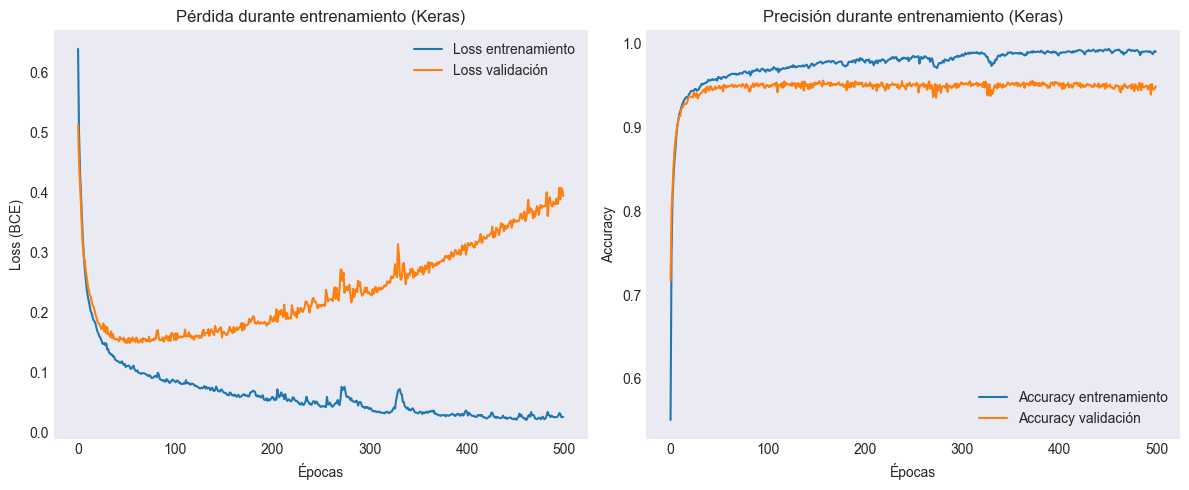

Keras Test loss (BCE): 0.3131
Keras Test accuracy: 0.9492
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Reporte de clasificación (Keras):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2528
           1       0.93      0.92      0.93      1427

    accuracy                           0.95      3955
   macro avg       0.95      0.94      0.94      3955
weighted avg       0.95      0.95      0.95      3955



In [28]:
# Plot de Loss y Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.xlabel('Épocas')
plt.ylabel('Loss (BCE)')
plt.title('Pérdida durante entrenamiento (Keras)')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Precisión durante entrenamiento (Keras)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluación test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Keras Test loss (BCE): {test_loss:.4f}")
print(f"Keras Test accuracy: {test_acc:.4f}")

# Predicciones binarias en test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Reporte de clasificación (Keras):")
print(classification_report(y_test, y_pred))

In [30]:
# Convertir a tensores (usando tus variables ya definidas)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Modelo
class MLP(nn.Module):
    def __init__(self, input_dim, num_nodes=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train_t.shape[1], num_nodes=num_nodes)

# Optimizador y criterio
learning_rate = lr
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# Entrenamiento
epochs = epochs
batch_size = batch_size

losses_train = []
losses_val = []

start_time = time.time()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_t)
        loss_val = criterion(y_val_pred, y_test_t)

    losses_train.append(loss.item())
    losses_val.append(loss_val.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss train: {loss.item():.4f}, Loss val: {loss_val.item():.4f}")

end_time = time.time()
elapsed = end_time - start_time
print(f"Tiempo de entrenamiento PyTorch: {elapsed:.2f} segundos")

Epoch 50/500 - Loss train: 0.1917, Loss val: 0.1982
Epoch 100/500 - Loss train: 0.1420, Loss val: 0.1584
Epoch 150/500 - Loss train: 0.1166, Loss val: 0.1459
Epoch 200/500 - Loss train: 0.1078, Loss val: 0.1396
Epoch 250/500 - Loss train: 0.1028, Loss val: 0.1442
Epoch 300/500 - Loss train: 0.1179, Loss val: 0.1494
Epoch 350/500 - Loss train: 0.0930, Loss val: 0.1419
Epoch 400/500 - Loss train: 0.0898, Loss val: 0.1411
Epoch 450/500 - Loss train: 0.0851, Loss val: 0.1441
Epoch 500/500 - Loss train: 0.0849, Loss val: 0.1445
Tiempo de entrenamiento PyTorch: 21.08 segundos


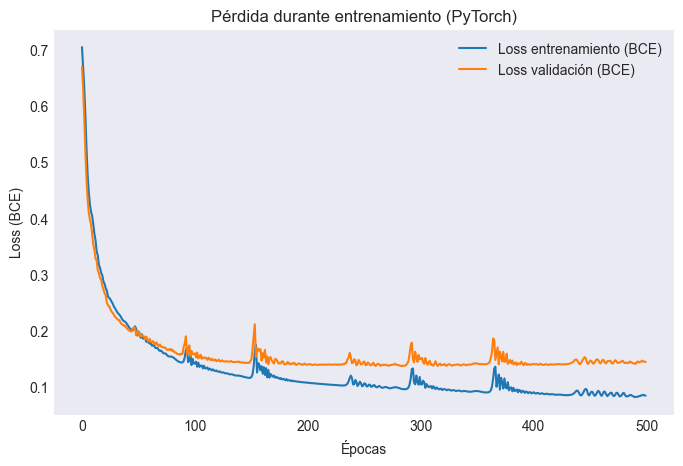

PyTorch Test accuracy: 0.9527
Reporte de clasificación (PyTorch):
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      2528
         1.0       0.94      0.93      0.93      1427

    accuracy                           0.95      3955
   macro avg       0.95      0.95      0.95      3955
weighted avg       0.95      0.95      0.95      3955



In [34]:
# Gráficos de pérdida
plt.figure(figsize=(8,5))
plt.plot(losses_train, label='Loss entrenamiento (BCE)')
plt.plot(losses_val, label='Loss validación (BCE)')
plt.xlabel('Épocas')
plt.ylabel('Loss (BCE)')
plt.title('Pérdida durante entrenamiento (PyTorch)')
plt.legend()
plt.grid()
plt.show()

# Evaluar test
model.eval()
with torch.no_grad():
    y_test_pred_prob = model(X_test_t).numpy()
    y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print(f"PyTorch Test accuracy: {accuracy_score(y_test_t, y_test_pred):.4f}")
print("Reporte de clasificación (PyTorch):")
print(classification_report(y_test_t, y_test_pred))

Aquí se observa claramente que los modelos mejoraron GRANDEMENTE al agregar los parámetros físicos adicionales. Los valores de precisión y recall, usando ambas librerías con la función de pérdida BCE, alcanzaron valores muy similares, cercanos o superiores a 0.95 en todos los casos. Esto indica que incluir estos parámetros adicionales permitió que las redes fueran mucho más certeras para clasificar galaxias como elípticas o no.

Se volvió a notar un fuerte sobreajuste usando Keras, donde la loss en el conjunto de validación nunca bajó de aproximadamente 0.2, e incluso empeoró después de alcanzarlo, terminando cerca de 0.4. Este sobreajuste se manifestó temprano en el entrenamiento. Por otro lado, Torch mostró un comportamiento mucho más estable, con una disminución gradual y sostenida de la loss en validación sin empeorar.

Sin embargo, creo que es importante tener una última reflexión sobre si es "válido" usar estos parámetros adicionales en el modelo o si esto podría considerarse una forma de “trampa”. Esto sería el caso si esos datos ya contienen, directa o indirectamente, información que revela si una galaxia es elíptica o no, por lo que el modelo estaría aprendiendo un atajo más que una característica intrínseca. Esta idea fue mencionada por Cecilia en clase. Pero no me parece evidente a priori que estos parámetros estén tan fuertemente correlacionados con la clase elíptica, dado que la matriz de correlación no mostró valores altos. Por esa razón decidí incluirlos en el análisis y evaluar qué impacto tienen.